# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.514976,True,4.359550
1,-0.394631,False,0.032995
2,0.561182,False,1.599352
3,-0.494669,False,0.425168
4,-0.271945,False,-1.305567
...,...,...,...
995,-1.257283,False,-3.344791
996,-1.112895,False,-2.094263
997,0.874417,True,5.275823
998,-2.079924,False,-4.302216


<Axes: xlabel='v0'>

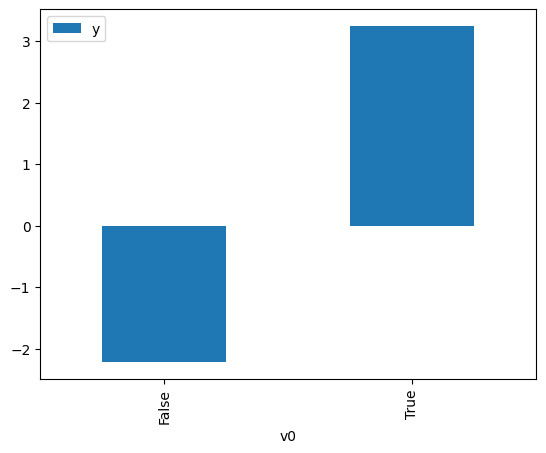

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

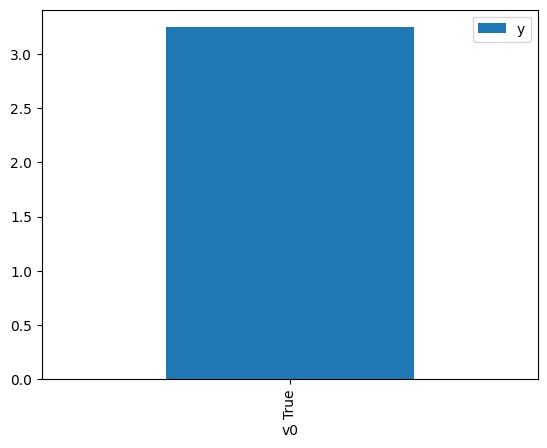

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.310720,False,-0.750905,0.909984,1.098920
1,-1.038948,False,-3.626635,0.859885,1.162946
2,-1.327176,False,-2.421717,0.912429,1.095976
3,-0.477815,False,-1.076627,0.686504,1.456656
4,-1.565529,False,-4.138983,0.941662,1.061952
...,...,...,...,...,...
995,0.789350,False,1.814227,0.176056,5.680006
996,-1.004336,False,-1.228564,0.852050,1.173640
997,-1.008770,False,-2.473640,0.853073,1.172232
998,-1.451615,False,-3.745707,0.929050,1.076368


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.551920,True,4.154996,0.284975,3.509082
1,-0.997847,True,3.700572,0.149459,6.690819
2,-0.243847,True,5.277276,0.412377,2.424966
3,-0.527627,True,3.819995,0.294152,3.399605
4,-1.742947,True,3.288388,0.042811,23.358692
...,...,...,...,...,...
995,-0.567015,True,5.412767,0.279360,3.579613
996,-1.090371,True,2.748266,0.129119,7.744806
997,-0.597698,True,2.339863,0.268158,3.729141
998,0.066577,True,6.133428,0.553776,1.805784


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7440.
Date:                Mon, 04 Dec 2023   Prob (F-statistic):                        0.00
Time:                        16:13:30   Log-Likelihood:                         -1433.4
No. Observations:                1000   AIC:                                      2871.
Df Residuals:                     998   BIC:                                      2881.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.2096      0.023     97.727      0.000       2.165       2.254
x2             4.9977      0.066     76.044      0.000       4.869       5.127
==============================================================================
Omnibus:                        0.372   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.830   Jarque-Bera (JB):                0.287
Skew:                           0.033   Prob(JB):                        0.866
Kurtosis:                       3.050   Cond. No.                         2.91
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""